In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
import pandas as pd
from math import floor

from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from darts.models import TCNModel

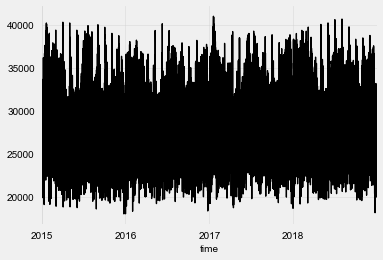

In [3]:
energy_df = pd.read_csv('energy_dataset.csv', usecols=['time', 'total load actual'])
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df['time']= energy_df.time.dt.tz_localize(None)

energy_series = TimeSeries.from_dataframe(energy_df, 'time', ['total load actual'])
energy_series.plot()
plt.show()

In [4]:
weather_df = pd.read_csv('weather_features.csv', usecols=['dt_iso', 'city_name', 'temp'])

def prep_city_series(df, city_name):
    df = weather_df[weather_df['city_name'] == city_name]
    df.drop(columns='city_name', inplace=True)
    temp_colname = 'temp_{}'.format(city_name)
    df.rename(columns = {'temp': temp_colname, 'dt_iso': 'time'}, inplace = True)
    df['time'] = pd.to_datetime(df['time'], utc=True)
    df['time'] = df.time.dt.tz_localize(None)
    df.drop_duplicates(subset='time', keep='first', inplace=True)
    city_series = TimeSeries.from_dataframe(df, 'time', temp_colname)
    return city_series

cities_to_keep = ['Madrid', 'Seville', 'Bilbao']
city_series = []
for city_name in cities_to_keep:
    city_series.append(prep_city_series(weather_df, city_name))

In [5]:
series = energy_series
for weather_series in city_series:
    series = series.stack(weather_series)

series = series[-floor((24*365*1.25)):]
series = series.add_datetime_attribute('weekday')
print(series)

                     total load actual  temp_Madrid  temp_Seville  \
time                                                                
2017-10-01 17:00:00            38818.0       300.15        306.54   
2017-10-01 18:00:00            38864.0       299.15        306.15   
2017-10-01 19:00:00            37883.0       296.93        303.76   
2017-10-01 20:00:00            34896.0       296.47        300.36   
2017-10-01 21:00:00            31439.0       295.48        298.15   
...                                ...          ...           ...   
2018-12-31 18:00:00            30653.0       283.56        287.76   
2018-12-31 19:00:00            29735.0       280.12        285.76   
2018-12-31 20:00:00            28071.0       278.15        285.15   
2018-12-31 21:00:00            25801.0       276.57        284.15   
2018-12-31 22:00:00            24455.0       275.15        283.97   

                     temp_Bilbao  time  
time                                    
2017-10-01 17:00:00 

In [6]:
series = MissingValuesFiller().transform(series)

scaler = Scaler()
series = scaler.fit_transform(series)

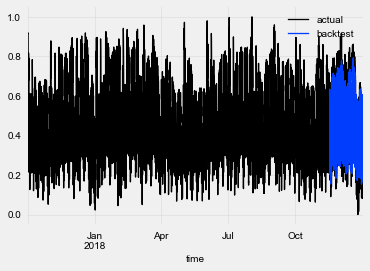

In [7]:
model = TCNModel(input_length=24*7,
                 input_size=5,
                 output_length=6,
                 output_size=1)

backtest = model.backtest(training_series=series,
                          target_series=series['0'],
                          start=0.9,
                          forecast_horizon=6,
                          stride=1,
                          retrain=False,
                          use_full_output_length=True,
                          verbose=True)


series['0'].plot(label="actual")
backtest.plot(label="backtest")
plt.legend()
plt.show()

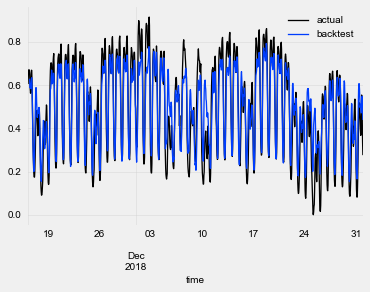

In [8]:
from darts.utils import get_timestamp_at_point
series['0'][get_timestamp_at_point(0.9, series):].plot(label="actual")
backtest.plot(label="backtest")
plt.legend()
plt.show()

In [9]:
from darts.metrics import smape

print(smape(series['0'], backtest))

18.64441002800342
